In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_csv('C:/Users/DELL/Desktop/aiproject/Smart water quality detector/Filtered_water_parameters.csv')

# Define features and target
features = [
    'Ammonia-Total (as N)', 'Conductivity @25°C', 'pH', 'Total Hardness (as CaCO3)'
]
target = 'WAWQI_Label'

# Add custom binary feature: 1 if (Conductivity > 600 and Hardness < 100), else 0
df['HighCond_LowHard'] = (
    (df['Conductivity @25°C'] > 0) & (df['Total Hardness (as CaCO3)'] < 300)
).astype(int)

# Add new feature to features list
features.append('HighCond_LowHard')

# Prepare features and target
X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9377545084351367

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.74      0.81       141
           1       0.93      0.83      0.88       120
           2       0.92      0.98      0.95       902
           3       0.98      0.84      0.91        51
           4       0.86      0.67      0.75        18
           5       0.99      0.97      0.98       487

    accuracy                           0.94      1719
   macro avg       0.93      0.84      0.88      1719
weighted avg       0.94      0.94      0.94      1719



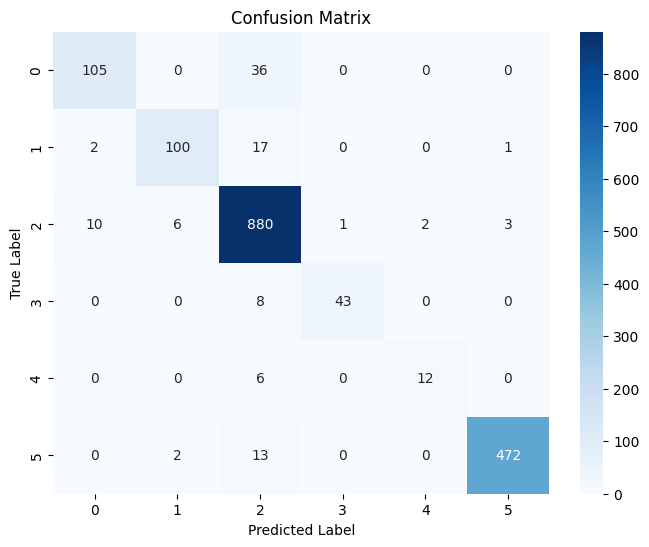


Top Important Features:
                     Feature  Importance
1         Conductivity @25°C    0.394451
3  Total Hardness (as CaCO3)    0.259537
0       Ammonia-Total (as N)    0.184321
2                         pH    0.159334
4           HighCond_LowHard    0.002357


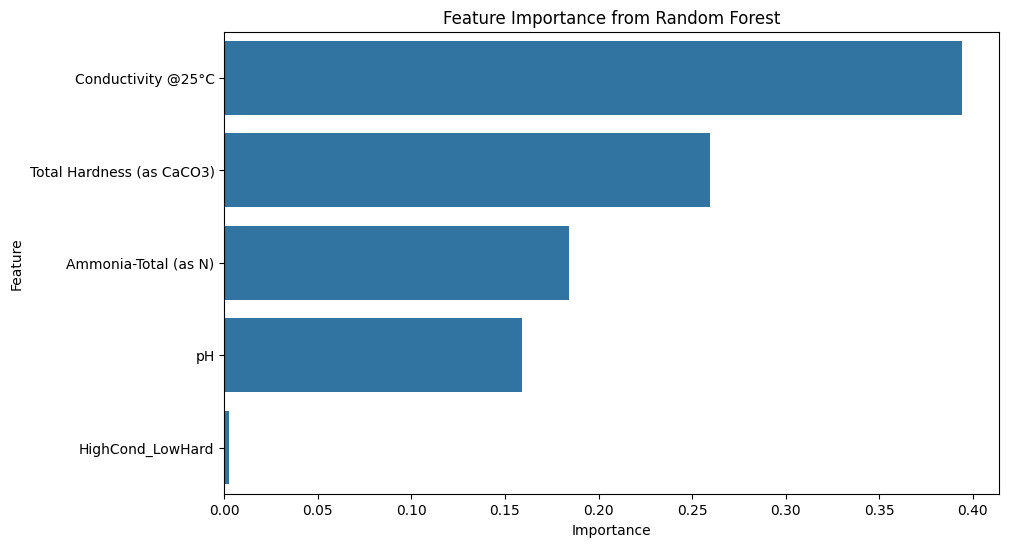

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict using the existing model on test set
y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Feature Importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop Important Features:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()


In [11]:
import joblib

# After training your model (e.g., model.fit(...)):

joblib.dump(model, 'model.joblib')
print("Model saved successfully!")


Model saved successfully!


In [14]:
import pandas as pd
import joblib

# Load saved model (no scaler used)
model = joblib.load("model.joblib")

# Define the feature columns used during training (including custom binary feature)
feature_columns = [
    'Ammonia-Total (as N)',
    'Conductivity @25°C',
    'pH',
    'Total Hardness (as CaCO3)',
    'HighCond_LowHard'  # Custom binary feature
]

# --- Custom input ---
custom_input = pd.DataFrame([{
    'Ammonia-Total (as N)': 0.1,
    'Conductivity @25°C': 300.0,
    'pH': 8.0,
    'Total Hardness (as CaCO3)': 0.0
}])

# Add the custom binary feature
custom_input['HighCond_LowHard'] = (
    (custom_input['Conductivity @25°C'] > 0) &
    (custom_input['Total Hardness (as CaCO3)'] < 300)
).astype(int)

# Align the columns in the same order used during training
custom_input = custom_input[feature_columns]

# Predict class and probabilities
prediction = model.predict(custom_input)[0]
probabilities = model.predict_proba(custom_input)[0]

# Map numeric prediction to WAWQI_Label
label_mapping = {
    0: 'Excellent',
    1: 'Fair',
    2: 'Good',
    3: 'Moderate',
    4: 'Poor',
    5: 'Unsuitable'
}

# Output
print(f"Predicted Class: {label_mapping.get(prediction, prediction)} ✅")
for i, prob in enumerate(probabilities):
    print(f"Probability of '{label_mapping.get(i, i)}': {prob*100:.2f}%")


Predicted Class: Unsuitable ✅
Probability of 'Excellent': 1.00%
Probability of 'Fair': 0.00%
Probability of 'Good': 3.00%
Probability of 'Moderate': 8.00%
Probability of 'Poor': 0.00%
Probability of 'Unsuitable': 88.00%


In [13]:
import pandas as pd
import joblib

# Load the model
model = joblib.load("model.joblib")

# Feature columns
feature_columns = [
    'Ammonia-Total (as N)',
    'Conductivity @25°C',
    'pH',
    'Total Hardness (as CaCO3)',
    'HighCond_LowHard'
]

# Label mapping
label_mapping = {
    0: 'Excellent',
    1: 'Fair',
    2: 'Good',
    3: 'Moderate',
    4: 'Poor',
    5: 'Unsuitable'
}

def test_wawqi_model_with_varying_params(model, base_input, step_sizes, steps=10):
    print("🔍 Sensitivity Analysis of WAWQI Model with Varying Parameters...\n")
    
    for param in base_input:
        print(f"\n📈 Varying '{param}' while keeping others constant:\n" + "-"*50)
        for i in range(steps + 1):
            sample = base_input.copy()
            sample[param] += i * step_sizes[param]
            
            # Compute custom binary feature
            cond = sample['Conductivity @25°C']
            hardness = sample['Total Hardness (as CaCO3)']
            sample['HighCond_LowHard'] = int(cond > 0 and hardness < 300)

            # Prepare DataFrame in model's expected order
            df_sample = pd.DataFrame([sample])[feature_columns]

            # Predict
            prediction = model.predict(df_sample)[0]
            label = label_mapping.get(prediction, prediction)
            print(f"{param} = {sample[param]:.2f} --> Predicted Class: {label}")

# Example safe base input
base_input = {
    'Ammonia-Total (as N)': 0.033,
    'Conductivity @25°C': 250,
    'pH': 7.50,
    'Total Hardness (as CaCO3)': 71.5  # < 300 triggers HighCond_LowHard = 1
}

# Step sizes for each parameter
step_sizes = {
    'Ammonia-Total (as N)': 0.005,
    'Conductivity @25°C': 20,
    'pH': -0.2,
    'Total Hardness (as CaCO3)': 50
}

# Run sensitivity test
test_wawqi_model_with_varying_params(model, base_input, step_sizes, steps=10)


🔍 Sensitivity Analysis of WAWQI Model with Varying Parameters...


📈 Varying 'Ammonia-Total (as N)' while keeping others constant:
--------------------------------------------------
Ammonia-Total (as N) = 0.03 --> Predicted Class: Excellent
Ammonia-Total (as N) = 0.04 --> Predicted Class: Good
Ammonia-Total (as N) = 0.04 --> Predicted Class: Good
Ammonia-Total (as N) = 0.05 --> Predicted Class: Good
Ammonia-Total (as N) = 0.05 --> Predicted Class: Fair
Ammonia-Total (as N) = 0.06 --> Predicted Class: Unsuitable
Ammonia-Total (as N) = 0.06 --> Predicted Class: Unsuitable
Ammonia-Total (as N) = 0.07 --> Predicted Class: Unsuitable
Ammonia-Total (as N) = 0.07 --> Predicted Class: Unsuitable
Ammonia-Total (as N) = 0.08 --> Predicted Class: Unsuitable
Ammonia-Total (as N) = 0.08 --> Predicted Class: Unsuitable

📈 Varying 'Conductivity @25°C' while keeping others constant:
--------------------------------------------------
Conductivity @25°C = 250.00 --> Predicted Class: Excellent
Conductivi

In [16]:
import numpy as np
import pandas as pd
import joblib

# Load trained model
model = joblib.load("model.joblib")

# Feature columns (must match training)
feature_columns = [
    'Ammonia-Total (as N)',
    'Conductivity @25°C',
    'pH',
    'Total Hardness (as CaCO3)',
    'HighCond_LowHard'
]

# Label mapping
label_mapping = {
    0: 'Excellent',
    1: 'Fair',
    2: 'Good',
    3: 'Moderate',
    4: 'Poor',
    5: 'Unsuitable'
}

# --- Input: Two past readings (oldest first, latest last) ---
past_readings = np.array([
    [0.01, 120.0, 7.0, 17.0],  # Older
    [0.02, 135.0, 7.3, 20.0]     # Latest
])

# Calculate rate of change
rate_of_change = past_readings[1] - past_readings[0]
current = past_readings[1]

unsafe_detected = False

# Simulate next 5 time steps
for step in range(1, 6):
    future = current + step * rate_of_change

    # Create DataFrame
    future_df = pd.DataFrame([{
        'Ammonia-Total (as N)': future[0],
        'Conductivity @25°C': future[1],
        'pH': future[2],
        'Total Hardness (as CaCO3)': future[3],
    }])

    # Add custom binary feature
    future_df['HighCond_LowHard'] = (
        (future_df['Conductivity @25°C'] > 0) &
        (future_df['Total Hardness (as CaCO3)'] < 300)
    ).astype(int)

    # Align columns
    future_df = future_df[feature_columns]

    # Predict
    prediction = model.predict(future_df)[0]
    probabilities = model.predict_proba(future_df)[0]
    label = label_mapping.get(prediction, prediction)

    print(f"\n🕒 Time Step {step}:")
    print(f"Input: {future.round(2)}")
    print(f"Predicted Class: {label} ✅")
    for i, prob in enumerate(probabilities):
        print(f"  → Probability of '{label_mapping.get(i, i)}': {prob*100:.2f}%")

    # Flag as unsafe if class is 'Poor' or 'Unsuitable'
    if prediction >= 4:
        unsafe_detected = True

# Final alert
print("\n🔔 Final Status:")
if unsafe_detected:
    print("⚠️ ALERT: Unsafe water quality (Poor/Unsuitable) predicted in future readings!")
else:
    print("✅ Water quality remains acceptable in all predicted steps.")



🕒 Time Step 1:
Input: [3.0e-02 1.5e+02 7.6e+00 2.3e+01]
Predicted Class: Good ✅
  → Probability of 'Excellent': 18.00%
  → Probability of 'Fair': 0.00%
  → Probability of 'Good': 69.00%
  → Probability of 'Moderate': 1.00%
  → Probability of 'Poor': 0.00%
  → Probability of 'Unsuitable': 12.00%

🕒 Time Step 2:
Input: [4.00e-02 1.65e+02 7.90e+00 2.60e+01]
Predicted Class: Good ✅
  → Probability of 'Excellent': 23.00%
  → Probability of 'Fair': 6.00%
  → Probability of 'Good': 61.00%
  → Probability of 'Moderate': 0.00%
  → Probability of 'Poor': 0.00%
  → Probability of 'Unsuitable': 10.00%

🕒 Time Step 3:
Input: [5.0e-02 1.8e+02 8.2e+00 2.9e+01]
Predicted Class: Unsuitable ✅
  → Probability of 'Excellent': 5.00%
  → Probability of 'Fair': 0.00%
  → Probability of 'Good': 24.00%
  → Probability of 'Moderate': 1.00%
  → Probability of 'Poor': 2.00%
  → Probability of 'Unsuitable': 68.00%

🕒 Time Step 4:
Input: [6.00e-02 1.95e+02 8.50e+00 3.20e+01]
Predicted Class: Unsuitable ✅
  → Proba